In [22]:
import pandas as pd
import numpy as np
from benchmarks import *
import glob
import os, sys
import seaborn as sns
import matplotlib.pyplot as plt
import re
import time
from tqdm.notebook import tqdm
import matplotlib.colors as mcolors
from matplotlib import cm

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)

In [2]:
MACHINE = 'lassen' if 'lassen' in ROOT_DIR else 'ruby'
print(MACHINE, ROOT_DIR)
prognames = list(progs.keys())
probsizes = ['smlprob', 'medprob', 'lrgprob']

dbFile = f'{MACHINE}-fullExploreDataset.csv'
print(dbFile)
xtimeDB = pd.read_csv(ROOT_DIR+'/databases/'+dbFile)

# drop cg_nas and cfd_rodinia
xtimeDB = xtimeDB[(xtimeDB['progname'] != 'cg_nas') & (xtimeDB['progname'] != 'cfd_rodinia')]

xtimeDB = xtimeDB.drop(['stddev'], axis=1)

xtimeDB['OMP_SCHEDULE'] = pd.Categorical(xtimeDB['OMP_SCHEDULE'], ['dynamic,1', 'dynamic,8', 'dynamic,32', 'dynamic,64', 'dynamic,128', 'dynamic,256', 'dynamic,512', 'guided,1', 'guided,8', 'guided,32', 'guided,64', 'guided,128', 'guided,256', 'guided,512', 'static', 'static,1', 'static,8', 'static,32', 'static,64', 'static,128', 'static,256', 'static,512'])
xtimeDB = xtimeDB.sort_values(by=['OMP_SCHEDULE', 'progname', 'probsize', 'OMP_NUM_THREADS', 'OMP_PROC_BIND', 'OMP_PLACES'])

xtimeDB = xtimeDB.astype({'OMP_SCHEDULE':'object'})

ruby /usr/WS2/bolet1/ruby-benchmarks/exploreGlobalOptimizations
ruby-fullExploreDataset.csv


In [3]:
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]


for col in list(xtimeDB.columns):
	uniq = list(xtimeDB[col].unique())
	print(col, uniq)
	if isinstance(uniq[0], str):
		uniq.sort(key=natural_keys)
		print(col, uniq)

progname ['bt_nas', 'ft_nas', 'hpcg', 'lulesh']
progname ['bt_nas', 'ft_nas', 'hpcg', 'lulesh']
probsize ['lrgprob', 'medprob', 'smlprob']
probsize ['lrgprob', 'medprob', 'smlprob']
OMP_NUM_THREADS [4, 8, 14, 28, 42, 56, 70, 84, 98, 112]
OMP_PROC_BIND ['close', 'spread']
OMP_PROC_BIND ['close', 'spread']
OMP_PLACES ['cores', 'sockets', 'threads']
OMP_PLACES ['cores', 'sockets', 'threads']
OMP_SCHEDULE ['dynamic,1', 'dynamic,8', 'dynamic,32', 'dynamic,64', 'dynamic,128', 'dynamic,256', 'dynamic,512', 'guided,1', 'guided,8', 'guided,32', 'guided,64', 'guided,128', 'guided,256', 'guided,512', 'static', 'static,1', 'static,8', 'static,32', 'static,64', 'static,128', 'static,256', 'static,512']
OMP_SCHEDULE ['dynamic,1', 'dynamic,8', 'dynamic,32', 'dynamic,64', 'dynamic,128', 'dynamic,256', 'dynamic,512', 'guided,1', 'guided,8', 'guided,32', 'guided,64', 'guided,128', 'guided,256', 'guided,512', 'static', 'static,1', 'static,8', 'static,32', 'static,64', 'static,128', 'static,256', 'static,

In [4]:
# normalize the xtime space to be between (optimal-2*baseline, optimal)
print(xtimeDB.columns)

numthreads = 112 if MACHINE == 'ruby' else 160

baselines = xtimeDB[(xtimeDB['OMP_NUM_THREADS'] == numthreads)&
										(xtimeDB['OMP_PROC_BIND'] == 'close')&
										(xtimeDB['OMP_PLACES'] == 'threads')&
										(xtimeDB['OMP_SCHEDULE'] == 'static') ]

optimals = xtimeDB.groupby(['progname', 'probsize'])['xtime'].min().reset_index()

baselines = baselines.set_index(['progname', 'probsize'])
optimals = optimals.set_index(['progname', 'probsize'])

print('baselines')
print(baselines)

print('optimals')
print(optimals)

#baselines['max'] = optimals['xtime']+(2*(baselines['xtime']-optimals['xtime']))
#baselines['min'] = optimals['xtime']


#norm = baselines[['min', 'max']]
#print(norm)


Index(['progname', 'probsize', 'OMP_NUM_THREADS', 'OMP_PROC_BIND', 'OMP_PLACES', 'OMP_SCHEDULE', 'xtime'], dtype='object')
baselines
                   OMP_NUM_THREADS OMP_PROC_BIND OMP_PLACES OMP_SCHEDULE       xtime
progname probsize                                                                   
bt_nas   lrgprob               112         close    threads       static  780.003333
         medprob               112         close    threads       static   40.626667
         smlprob               112         close    threads       static    7.596667
ft_nas   lrgprob               112         close    threads       static  450.383333
         medprob               112         close    threads       static    4.803333
         smlprob               112         close    threads       static    1.136667
hpcg     lrgprob               112         close    threads       static   80.117400
         medprob               112         close    threads       static   25.454767
         smlprob 

In [5]:
# Now let's normalize all the data

normed = xtimeDB.copy(deep=True).set_index(['progname', 'probsize'])
#normed = normed.drop(['stddev'], axis=1)

for col in list(normed.columns):
	print(col, len(list(normed[col].unique())))

print(normed.dtypes)
print(normed)

normed.loc[:, 'xtime'] = normed.apply(lambda x: baselines.loc[x.name, 'xtime']/x['xtime'] ,axis=1)
#normed.loc[:, 'xtime'] = baselines['xtime']/normed['xtime']
#normed.loc[:, 'xtime'] = (normed['xtime']-norm['min'])/(norm['max']-norm['min'])

# for the really long xtimes, cap them out at 1
#normed.loc[normed['xtime'] > 1, 'xtime'] = 1

# now reverse the scale so 0 is worst and 1 is best
#normed.loc[:, 'xtime'] = 1 - normed['xtime']

print(normed, normed['xtime'].max()) 

OMP_NUM_THREADS 10
OMP_PROC_BIND 2
OMP_PLACES 3
OMP_SCHEDULE 22
xtime 13226
OMP_NUM_THREADS      int64
OMP_PROC_BIND       object
OMP_PLACES          object
OMP_SCHEDULE        object
xtime              float64
dtype: object
                   OMP_NUM_THREADS OMP_PROC_BIND OMP_PLACES OMP_SCHEDULE        xtime
progname probsize                                                                    
bt_nas   lrgprob                 4         close      cores    dynamic,1  4500.000000
         lrgprob                 4         close    sockets    dynamic,1  4500.000000
         lrgprob                 4         close    threads    dynamic,1  4500.000000
         lrgprob                 4        spread      cores    dynamic,1  4500.000000
         lrgprob                 4        spread    sockets    dynamic,1  4500.000000
...                            ...           ...        ...          ...          ...
lulesh   smlprob               112         close    sockets   static,512    28.912732
 

In [6]:
# now that we have the normalized data, let's plot it

df = normed.copy(deep=True)

df['OMP_SCHED_PROC_BIND'] = [str(a) for a in list(zip(normed['OMP_SCHEDULE'], normed['OMP_PROC_BIND']))]
df['OMP_NUM_THREADS_PLACES'] = [str(a) for a in list(zip(normed['OMP_NUM_THREADS'], normed['OMP_PLACES']))]

df = df.drop(['OMP_NUM_THREADS', 'OMP_PROC_BIND', 'OMP_PLACES', 'OMP_SCHEDULE'], axis=1).reset_index()

print(df)
print(df.dtypes)
#print('\n'.join([', '.join(i) for i in list(df['OMP_SCHED_PROC_BIND'].unique())]))
#print('\n'.join([', '.join(i) for i in list(df['OMP_SCHED_PROC_BIND'].unique())]))

uniqA = list(df['OMP_SCHED_PROC_BIND'].unique())
uniqB = list(df['OMP_NUM_THREADS_PLACES'].unique())
print(len(uniqA), uniqA)
print(len(uniqB), uniqB)

      progname probsize     xtime       OMP_SCHED_PROC_BIND OMP_NUM_THREADS_PLACES
0       bt_nas  lrgprob  0.173334    ('dynamic,1', 'close')           (4, 'cores')
1       bt_nas  lrgprob  0.173334    ('dynamic,1', 'close')         (4, 'sockets')
2       bt_nas  lrgprob  0.173334    ('dynamic,1', 'close')         (4, 'threads')
3       bt_nas  lrgprob  0.173334   ('dynamic,1', 'spread')           (4, 'cores')
4       bt_nas  lrgprob  0.173334   ('dynamic,1', 'spread')         (4, 'sockets')
...        ...      ...       ...                       ...                    ...
15835   lulesh  smlprob  0.953356   ('static,512', 'close')       (112, 'sockets')
15836   lulesh  smlprob  1.007290   ('static,512', 'close')       (112, 'threads')
15837   lulesh  smlprob  1.022285  ('static,512', 'spread')         (112, 'cores')
15838   lulesh  smlprob  0.980072  ('static,512', 'spread')       (112, 'sockets')
15839   lulesh  smlprob  1.022330  ('static,512', 'spread')       (112, 'threads')

[15

In [29]:
def drawHeatmap(*args, **kwargs):
	data = kwargs.pop('data').copy(deep=True)
	if 'probsize' in list(data.columns):
		data = data.drop(['probsize'], axis=1)
	if 'progname' in list(data.columns):
		data = data.drop(['progname'], axis=1)
	data = data.pivot(index='OMP_SCHED_PROC_BIND', columns='OMP_NUM_THREADS_PLACES', values='xtime')
	# silly how we have to resort this manually...
	data.index = pd.CategoricalIndex(data.index, categories=uniqA)
	data.sort_index(level=0, inplace=True)

	data.columns = pd.CategoricalIndex(data.columns, categories=uniqB)
	data.sort_index(axis='columns', level='OMP_NUM_THREADS_PLACES', inplace=True)

	# for this data, create a custom colormap, want to show values at 1 with white, and less than 1 with red, and higher than 1 with blue
	#colors_underspeedup = cm.seismic(np.linspace(0, 0.5, 256))

	#print(data)
	# plot the good values
	#ax = sns.heatmap(data, norm=mcolors.CenteredNorm(vcenter=1.0, clip=True), cmap='seismic', **kwargs)
	ax = sns.heatmap(data, norm=mcolors.TwoSlopeNorm(vcenter=1.0), cmap='seismic', fmt='.3f', annot_kws={"fontsize":6}, **kwargs)
	# plot the never found values
	#sns.heatmap(data, mask=data >= 0, cmap=plt.get_cmap('binary'), vmin=-1, vmax=-1, ax=ax, cbar=False)


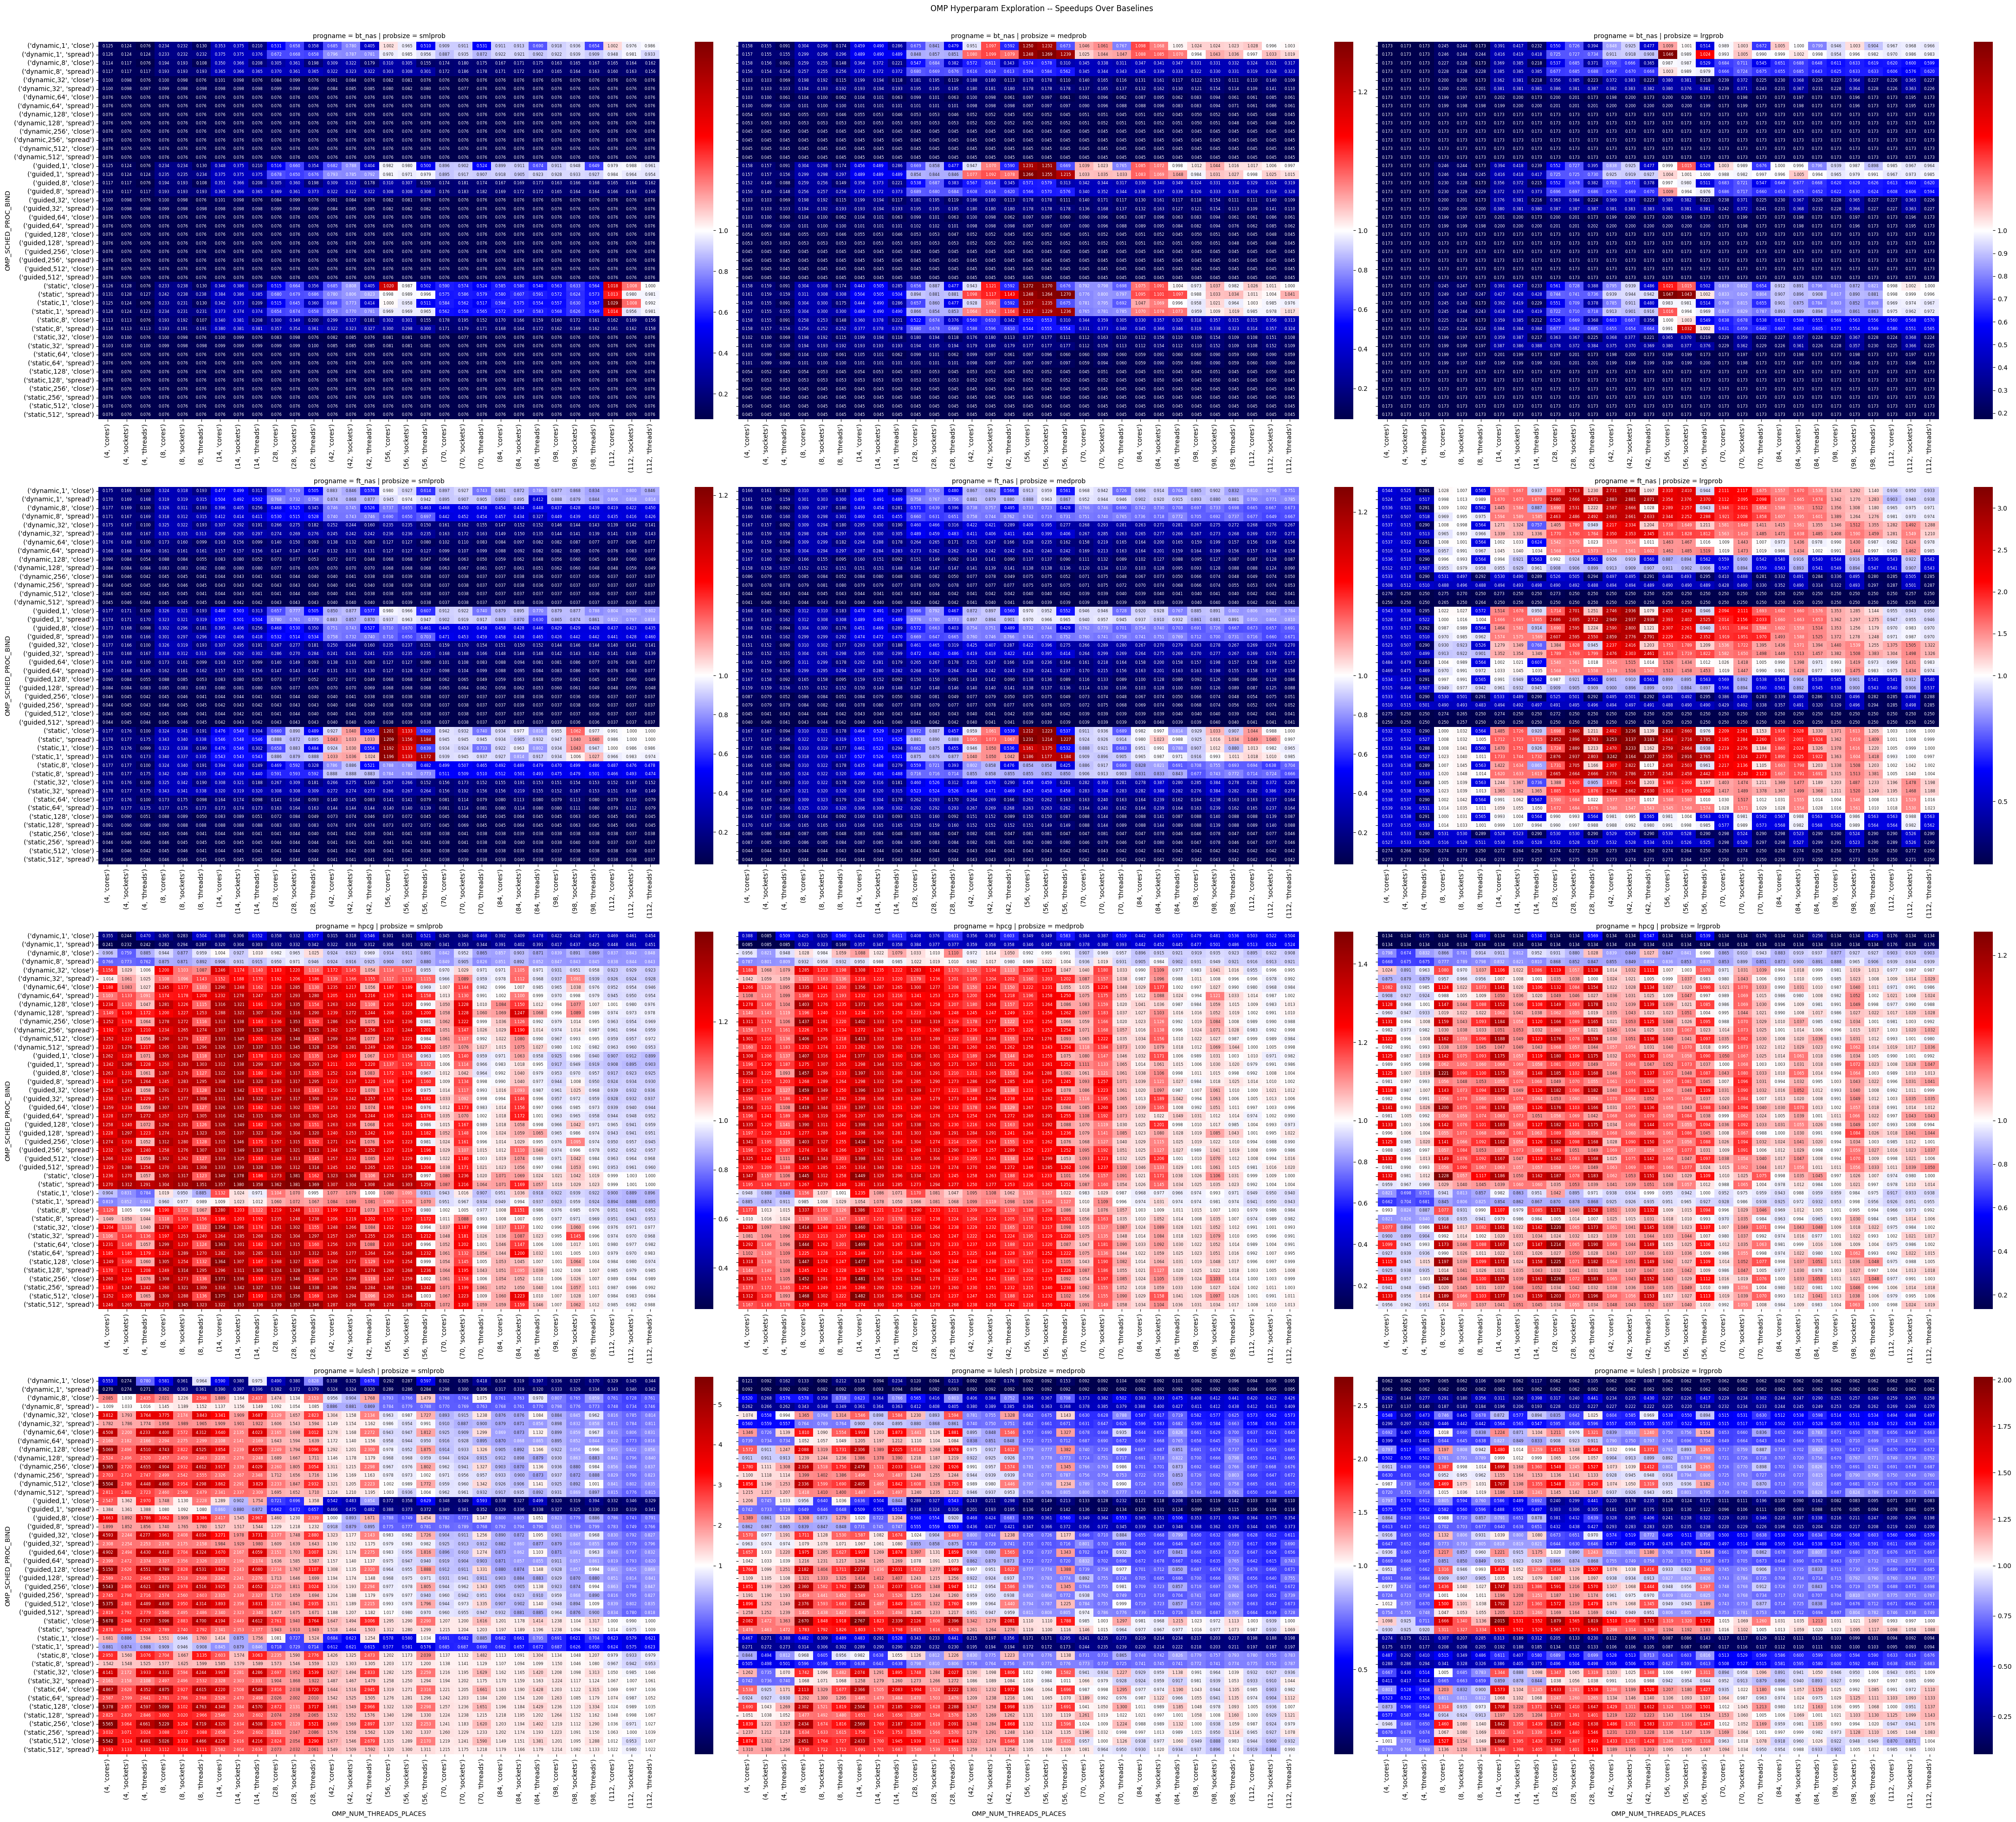

In [30]:

g = sns.FacetGrid(df, row='progname', col='probsize', col_order=probsizes, height=10, aspect=1.5)
#g.map_dataframe(drawHeatmap, annot=True, vmin=0.0, vmax=1.0, cbar=True)
g.map_dataframe(drawHeatmap, annot=True, cbar=True, vmin=0)


for ax in g.axes.flatten():
	ax.tick_params(axis='x', labelbottom=True, labelrotation=90)

plt.tight_layout()

g.fig.subplots_adjust(top=0.96)
g.fig.suptitle(f'OMP Hyperparam Exploration -- Speedups Over Baselines')

plt.show()

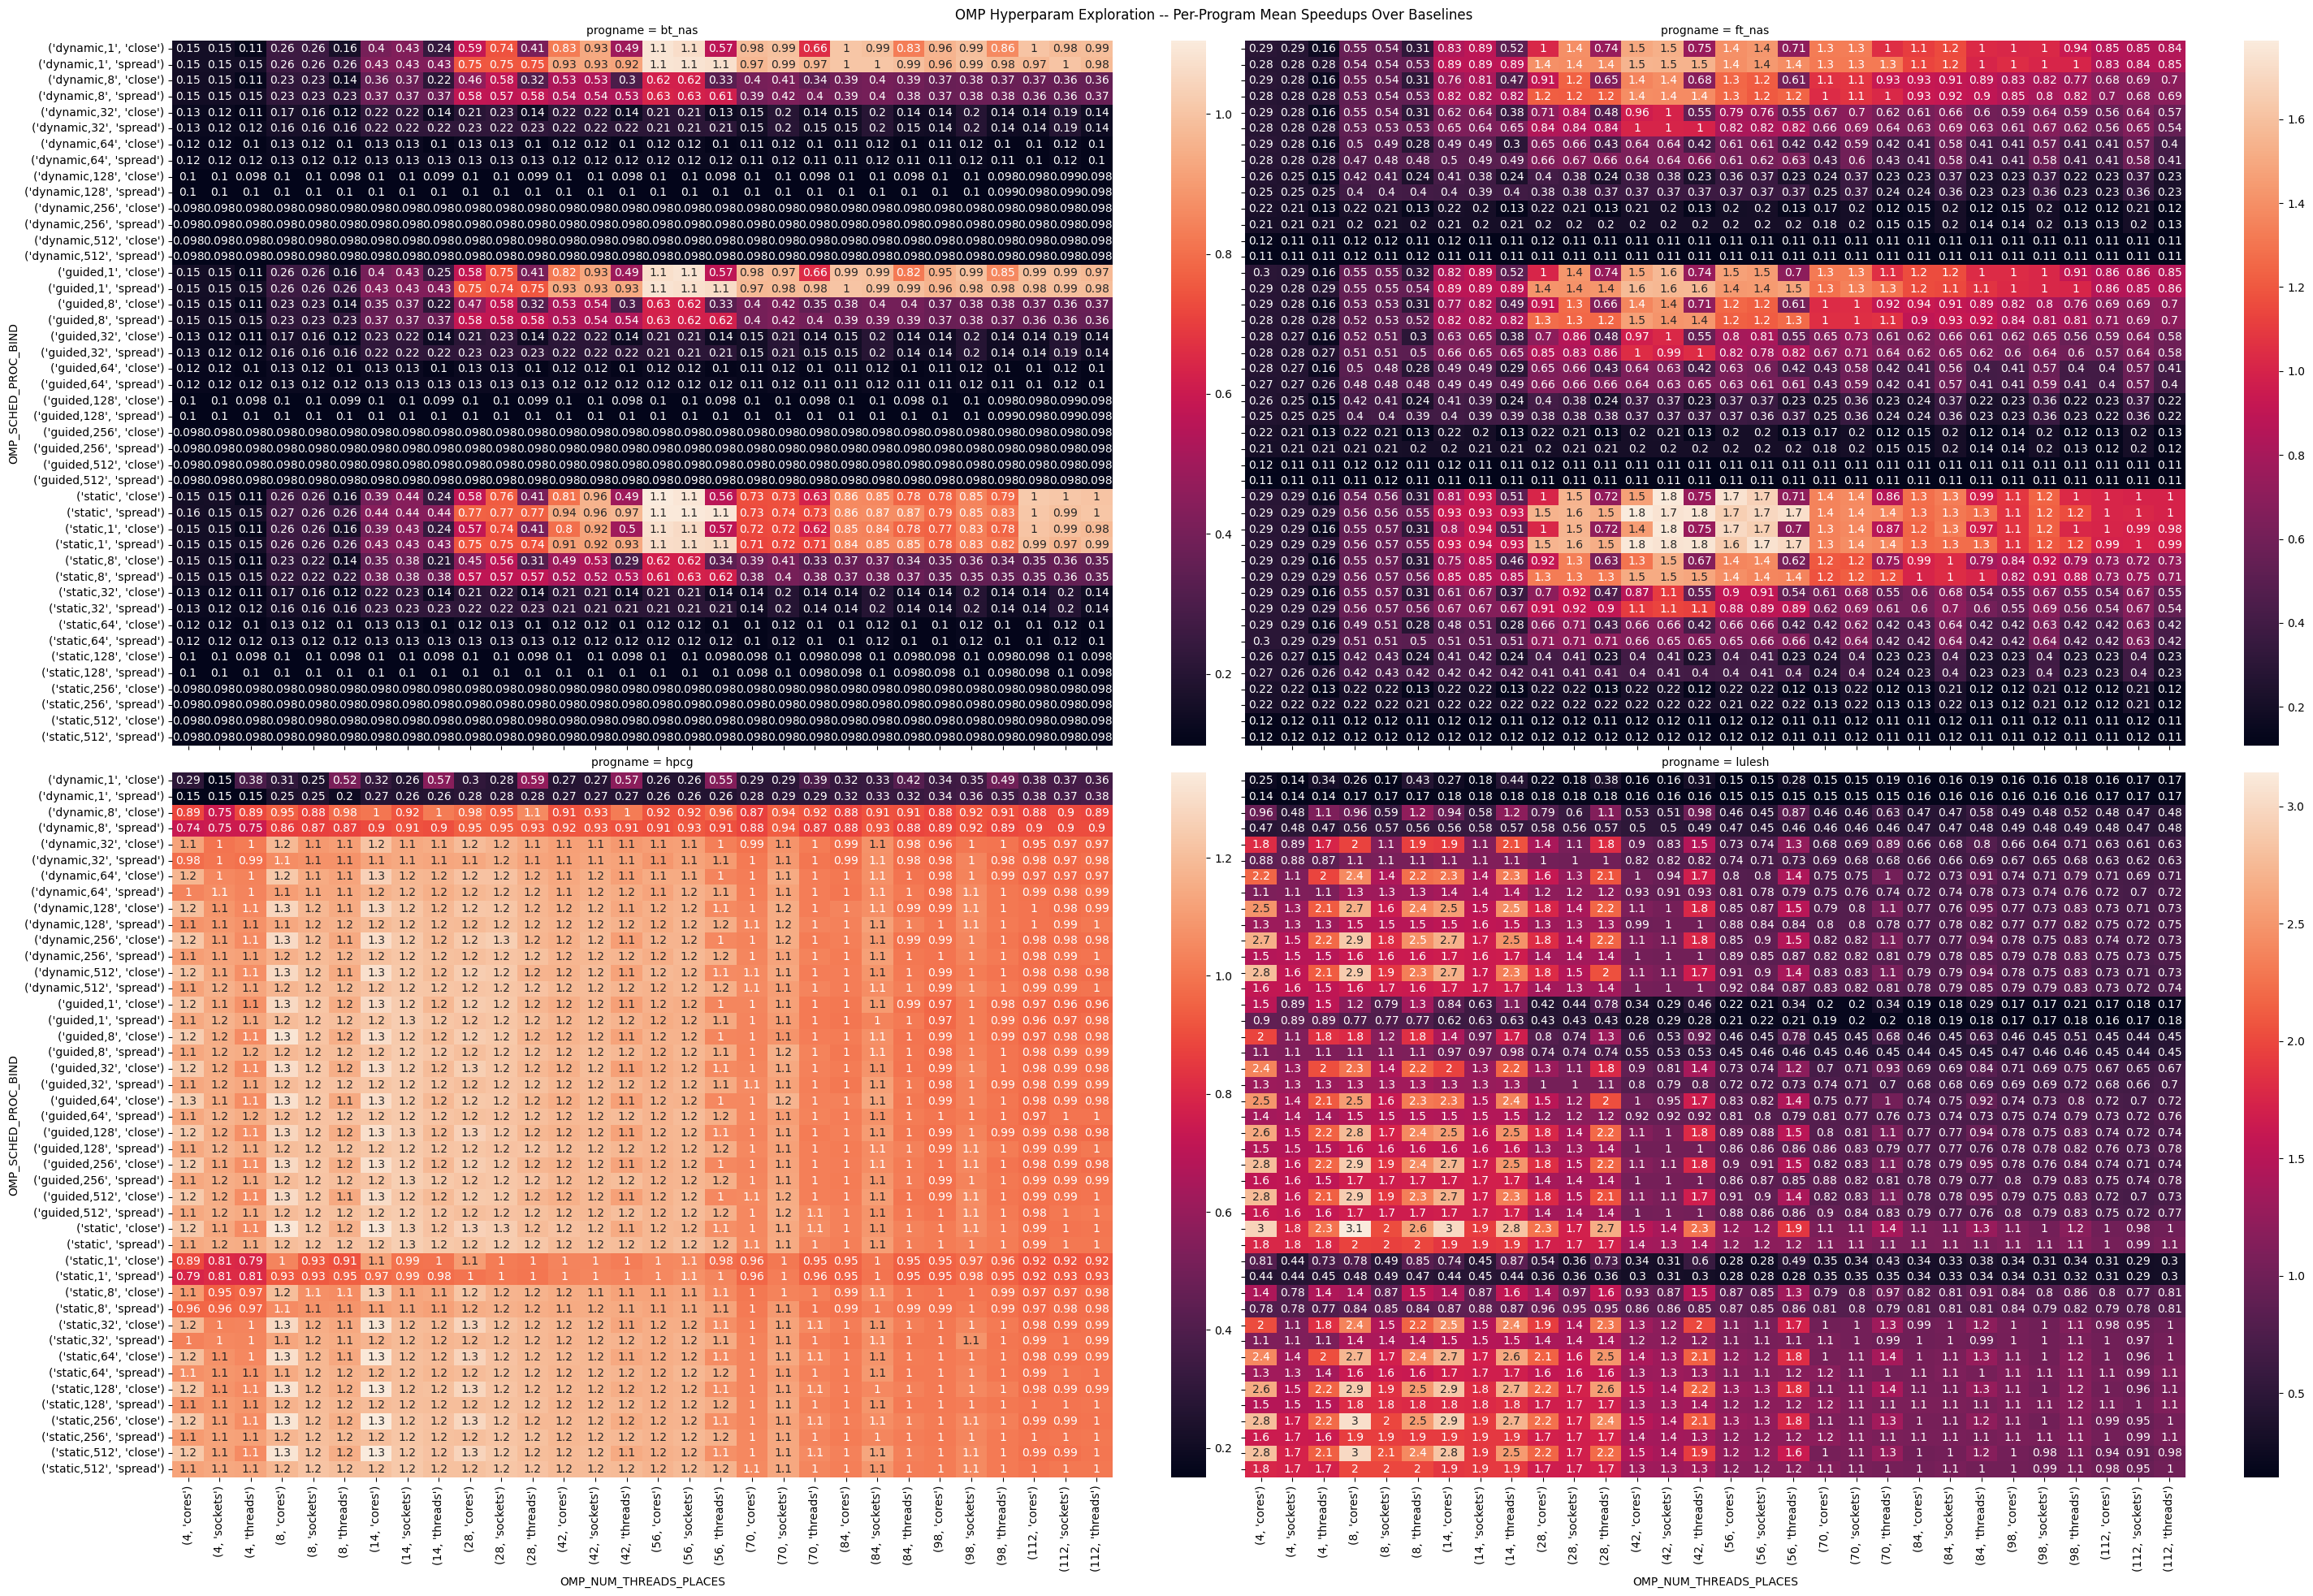

In [29]:
# now let's make one plot to summarize it all

#groupby the two columns and take the mean xtime

newdf = df.groupby(['progname', 'OMP_SCHED_PROC_BIND', 'OMP_NUM_THREADS_PLACES'])['xtime'].mean().reset_index()


g = sns.FacetGrid(newdf, col='progname', palette='flare', height=10, aspect=1.5, col_wrap=2)
#g.map_dataframe(drawHeatmap, annot=True, vmin=0.0, vmax=1.0, cbar=True)
g.map_dataframe(drawHeatmap, annot=True, cbar=True)

plt.tight_layout()

g.fig.subplots_adjust(top=0.96)
g.fig.suptitle(f'OMP Hyperparam Exploration -- Per-Program Mean Speedups Over Baselines')

plt.show()

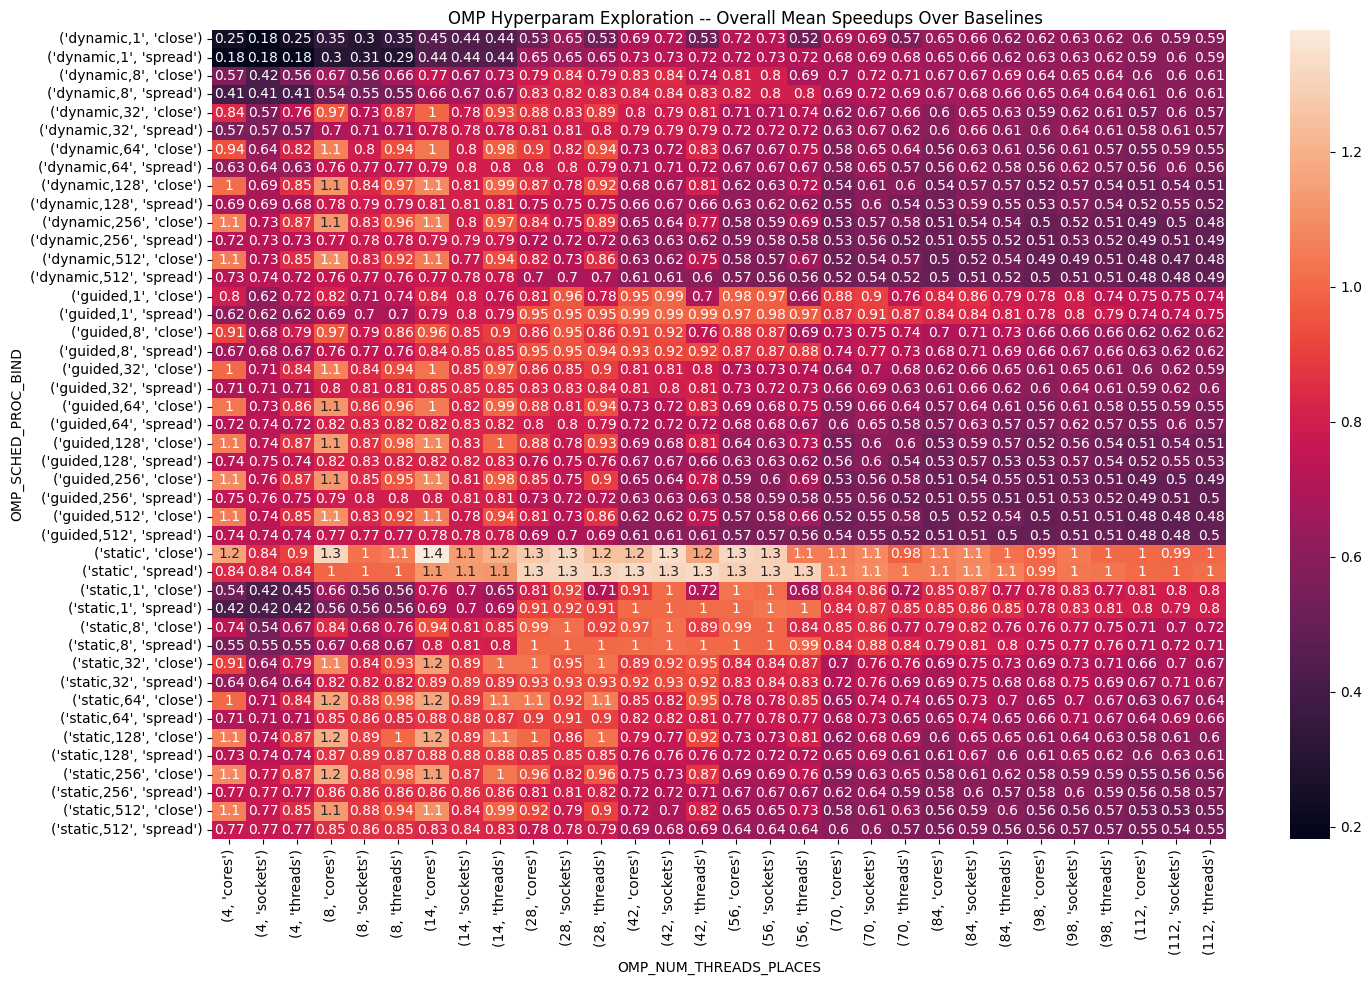

In [28]:

newnewdf = df.groupby(['OMP_SCHED_PROC_BIND', 'OMP_NUM_THREADS_PLACES'])['xtime'].mean().reset_index()


g = sns.FacetGrid(newnewdf, palette='flare', height=10, aspect=1.5)
#g.map_dataframe(drawHeatmap, annot=True, vmin=0.0, vmax=1.0, cbar=True)
g.map_dataframe(drawHeatmap, annot=True, cbar=True)

plt.tight_layout()

g.fig.subplots_adjust(top=0.96)
g.fig.suptitle(f'OMP Hyperparam Exploration -- Overall Mean Speedups Over Baselines')

plt.show()